# Problem 1: Random Walk Monte Carlo

Load the Line Fitting dataset (line_fitting.csv) and plot the data.

Write your own Random Walk MCMC algorithm from scratch. Don't worry if it is slow or inefficient - this exercise is about intuition building, not results. Use your sampler to fit a line to the data and generate samples from the posterior. For a first pass, run the sampler for a fixed number of steps, $N$. Then, modify the sampler to automatically stop running when a target number of effective samples $N_{\rm eff}$ has been reached.

# Problem 2: Fitting a Line

Load the Line Fitting dataset (line_fitting.csv) and plot the data.

a) Fit the data using an ensemble sampler of your choice (recommendation: `emcee`)

b) Fit the data using a Hamiltonian Monte Carlo Sampler of your choice (recommendation: `PyMC` or `NumPyro`)

c) Fit the data using a nested sampler of your choice (recommendation: `dynesty`, `UltraNest`)

For all three cases, explicity write down the likelihood function; the `emcee` documentation has a clear explanation of how to do this. For Nested Sampling, you will also need to write a prior transform function; the `dynesty` documentation has a clear explanation of how to do this. Play around with using different priors (e.g. Gaussian, Uniform, Log-Uniform) to get a feel for the syntax of the different packages.

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import emcee as em
import pymc3 as pmc
import pymc3_ext as pmx
import pandas as pd
from IPython.display import display, Math

from functools import partial
from scipy import stats

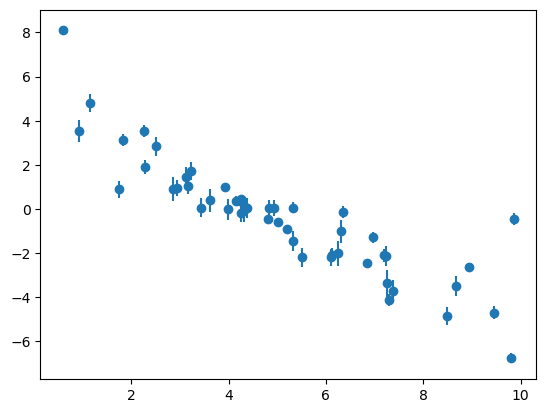

In [2]:
data = np.loadtxt("./line_fitting.csv", delimiter=",", skiprows=1)[:, 1:]

fig, ax = plt.subplots()
ax.errorbar(data[:, 0], data[:, 1], yerr=data[:, 2], fmt="o")
plt.show()

In [120]:
def model(x, m, b):
    return m * x + b

def ln_likelihood(theta, x, y, y_err):
    m, b, lnf = theta
    model_y = model(x, m, b)
    sigma2 = y_err**2 + np.exp(2 * lnf)
    return -0.5 * np.sum((y - model_y) ** 2 / sigma2 + np.log(sigma2))

def ln_prior(theta):
    m, b, lnf = theta
    if -10 < m < 10 and -10 < b < 10 and -5 < lnf < 5:
        return 0.0
    return -np.inf

def ln_posterior(theta, x, y, y_err):
    lp = ln_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ln_likelihood(theta, x, y, y_err)

In [121]:
n_walkers, n_dim = 50, 3
init_pos = np.array([-1, 3, 0]) + 1e-2 * np.random.randn(n_walkers, n_dim)

n_steps = 5000

sampler = em.EnsembleSampler(n_walkers, n_dim, ln_posterior, args=(data[:, 0], data[:, 1], data[:, 2]))

In [122]:
sampler.run_mcmc(init_pos, n_steps, progress=True)

100%|██████████| 5000/5000 [00:02<00:00, 1969.16it/s]


State([[-0.90093201  4.23413385  0.1504616 ]
 [-0.88196212  3.90152958  0.20625487]
 [-0.91388874  4.21925622  0.04581761]
 [-0.94646245  4.21925832  0.26040005]
 [-0.85804475  3.81725425  0.24721113]
 [-1.01605817  5.02122413  0.12938788]
 [-1.05085565  4.94811932  0.15917721]
 [-0.89981517  4.01308981  0.16938227]
 [-1.00794426  4.75792803  0.05390093]
 [-1.01115421  4.74252875  0.19306505]
 [-0.91199765  4.25671011  0.47047323]
 [-0.96594028  4.35618238  0.18909733]
 [-1.03901551  5.29304853  0.11777937]
 [-0.87114937  4.09315274  0.25967375]
 [-1.16376157  5.51267225  0.17727437]
 [-0.99005661  4.73761785  0.24759642]
 [-1.05013585  4.79766997  0.3990001 ]
 [-0.98643033  4.49810485  0.10364518]
 [-0.90566988  3.91015632  0.21620003]
 [-0.98410157  4.57975883  0.22947753]
 [-1.03374321  4.83391432  0.13394235]
 [-1.10690568  5.06283196  0.13341076]
 [-0.98583269  4.5450076   0.10269614]
 [-1.0736913   5.15355789  0.05356653]
 [-1.02463019  4.42785758  0.02486896]
 [-1.04787617  4.85

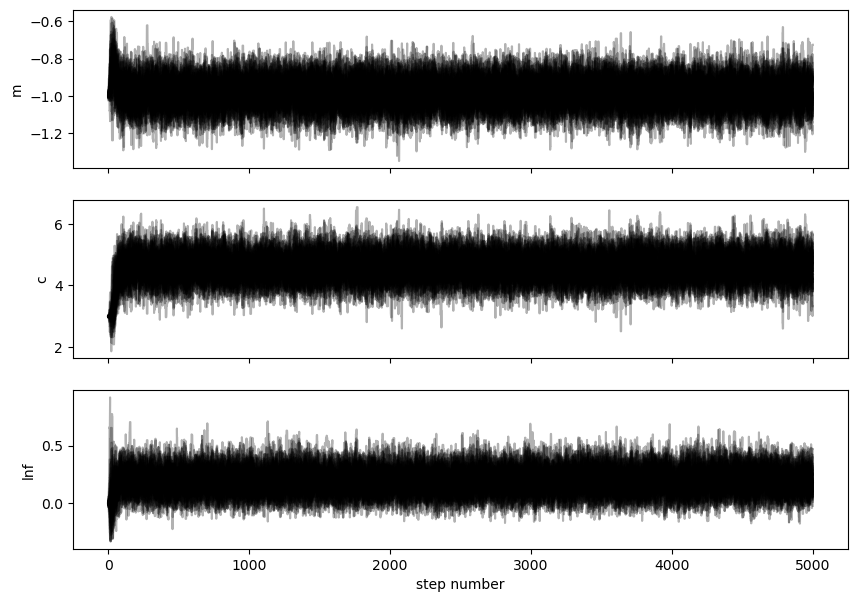

In [123]:
fig, ax = plt.subplots(3, 1, figsize=(10, 7), sharex=True)
ax[0].plot(sampler.chain[:, :, 0].T, color="k", alpha=0.3)
ax[0].set_ylabel("m")
ax[1].plot(sampler.chain[:, :, 1].T, color="k", alpha=0.3)
ax[1].set_ylabel("c")
ax[2].plot(sampler.chain[:, :, 2].T, color="k", alpha=0.3)
ax[2].set_ylabel("lnf")
ax[2].set_xlabel("step number")
plt.show()

In [124]:
print(sampler.get_autocorr_time())

[38.68485311 40.40469235 36.67505902]


In [125]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(16300, 3)


/Users/ullas/miniconda3/envs/dsfp/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


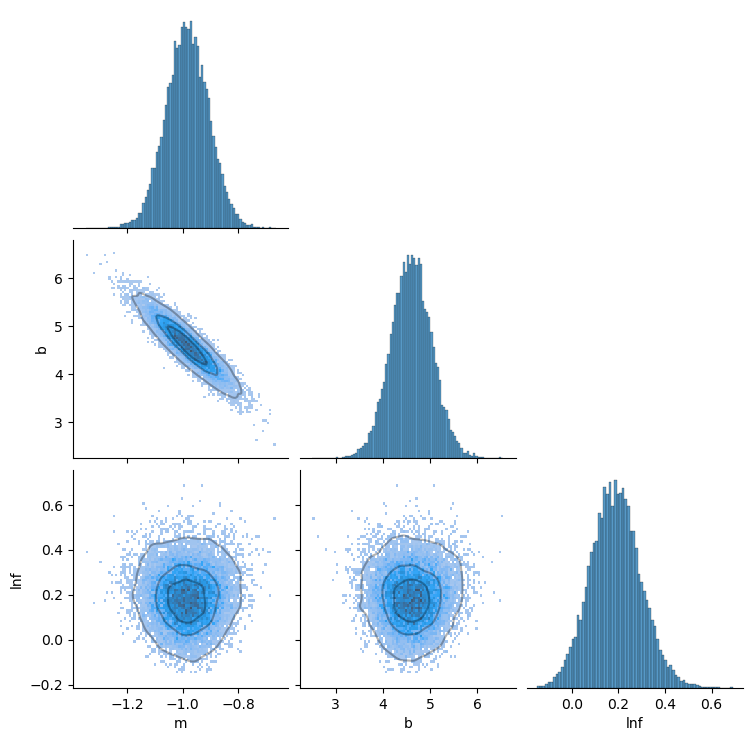

In [126]:
p = sns.pairplot(
    pd.DataFrame(flat_samples, columns=["m", "b", "lnf"]), kind="hist", corner=True
)
p.map_lower(sns.kdeplot, color="k", alpha=0.3, levels=4)

In [90]:
labels = ["m", "b", "lnf"]
for i in range(n_dim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [96]:
data

array([[ 0.59677897,  8.11257148,  0.16031433],
       [ 0.9210494 ,  3.52815075,  0.5131704 ],
       [ 1.15618395,  4.81023356,  0.40153006],
       [ 1.75451756,  0.89238164,  0.372534  ],
       [ 1.8249173 ,  3.13295195,  0.27138192],
       [ 2.26851454,  3.53338034,  0.25206039],
       [ 2.28263231,  1.89933975,  0.30851111],
       [ 2.50455365,  2.83896349,  0.44065038],
       [ 2.86139335,  0.89713921,  0.53772842],
       [ 2.93714046,  0.9500022 ,  0.35521117],
       [ 3.12261223,  1.45700044,  0.43465689],
       [ 3.17285482,  1.05318568,  0.39296828],
       [ 3.22958914,  1.71011605,  0.41245175],
       [ 3.43178016,  0.06780647,  0.43734453],
       [ 3.61788656,  0.40019114,  0.52117122],
       [ 3.92117518,  1.00444563,  0.14159749],
       [ 3.98044255, -0.02239716,  0.48184142],
       [ 4.14826212,  0.35714018,  0.22183319],
       [ 4.2310646 ,  0.36639252,  0.19711148],
       [ 4.2583029 , -0.20377166,  0.38622848],
       [ 4.26351307,  0.4535501 ,  0.147

In [114]:
x, y, y_err = data[:, 0], data[:, 1], data[:, 2]
with pmc.Model() as model:
    m = pmc.Uniform("m", -10, 10)
    c = pmc.Uniform("c", -10, 10)
    lnf = pmc.Normal("lnf", 0, 10)

    y_mod = pmc.Deterministic("model", m * x + c)
    s_mod = np.sqrt(y_err**2 + np.exp(2 * lnf))

    lnl = pmc.Normal("lnl", mu=y_mod, sd=s_mod, observed=y)

with model:
    trace = pmx.sample(
        chains=2, tune=1000, draws=1000, target_accept=0.9, return_inferencedata=True
    )

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [lnf, c, m]


/Users/ullas/miniconda3/envs/dsfp/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ullas/miniconda3/envs/dsfp/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.


Text(0, 0.5, 'lnf')

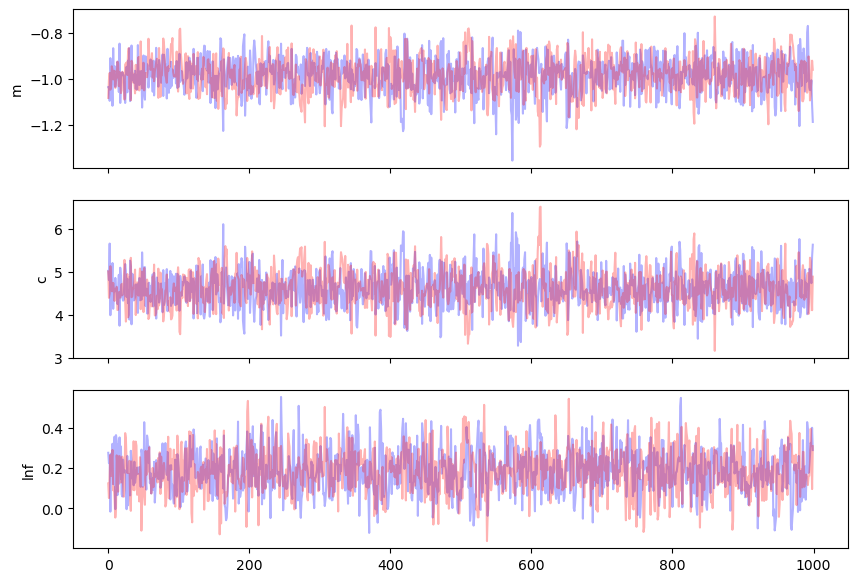

In [115]:
fig, ax = plt.subplots(3, 1, figsize=(10, 7), sharex=True)
ax[0].plot(trace.posterior["m"].values[0], color="b", alpha=0.3)
ax[0].plot(trace.posterior["m"].values[1], color="r", alpha=0.3)
ax[0].set_ylabel("m")
ax[1].plot(trace.posterior["c"].values[0], color="b", alpha=0.3)
ax[1].plot(trace.posterior["c"].values[1], color="r", alpha=0.3)
ax[1].set_ylabel("c")
ax[2].plot(trace.posterior["lnf"].values[0], color="b", alpha=0.3)
ax[2].plot(trace.posterior["lnf"].values[1], color="r", alpha=0.3)
ax[2].set_ylabel("lnf")

In [106]:
trace.posterior["m"].T

<xarray.DataArray 'm' (draw: 1000, chain: 2)>
array([[-0.96690844, -1.07366756],
       [-0.91188363, -1.15006678],
       [-0.90238017, -0.98603775],
       ...,
       [-0.94179947, -0.94142065],
       [-1.0861593 , -1.05280633],
       [-1.0626452 , -1.03060683]])
Coordinates:
  * chain    (chain) int64 0 1
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

# Problem 3: Astrophysics

Select an astrophysical dataset of your choosing. Fit the data using (a) an ensemble sampler, (b) HMC, and (c) Nested Sampling. Verify that the three methods produce equivalent results.